In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.morphology import disk
from sklearn.mixture import GaussianMixture
from skimage.morphology import skeletonize

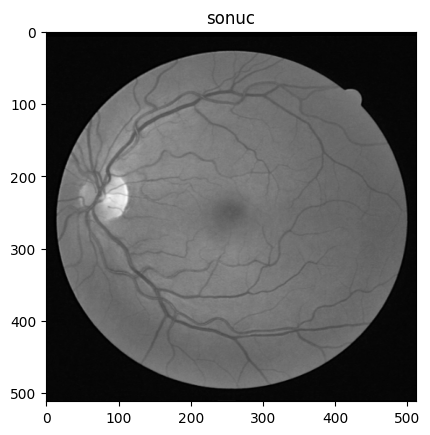

In [2]:
def goster(img):
    plt.title("sonuc")
    plt.imshow(img, cmap='gray')
    plt.show()

img_first = cv2.imread(r"..\sample\image.png")

img_green= img_first[:, :, 1]

goster(img_green)

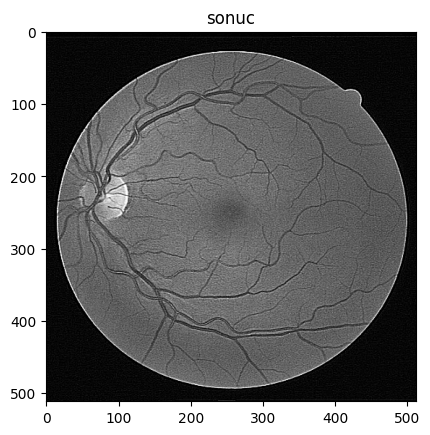

In [3]:
# Keskinleştirme kernel'i
kernel = np.array([[-1,-1,-1],
                  [-1, 9,-1],
                  [-1,-1,-1]])

# Keskinleştirme işlemi
sharpened = cv2.filter2D(img_green, -1, kernel)
goster(sharpened)

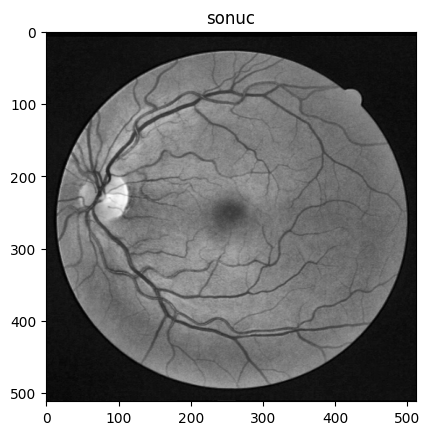

In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img_green)

goster(img_clahe)

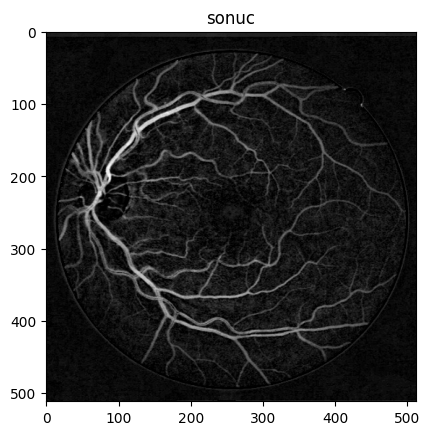

In [5]:
# Morfolojik işlem: Top-hat
se = disk(10)
J1 = cv2.morphologyEx((img_clahe * 255).astype(np.uint8), cv2.MORPH_TOPHAT, se)  # Top-hat morfolojisi
#J1=255-J1
goster(J1)

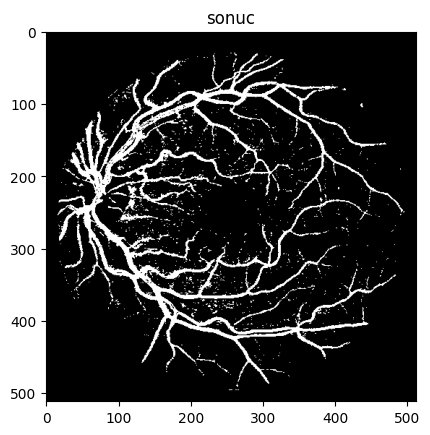

In [6]:
# Görüntüyü düzleştir ve yeniden şekillendir
piksel_degerleri = J1 .reshape(-1, 1)
    
# GMM modelini oluştur ve uygula
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(piksel_degerleri)
    
# Pikselleri sınıflandır
labels = gmm.predict(piksel_degerleri)
    
# Sonuç görüntüsünü oluştur
segmente_goruntu = labels.reshape(J1 .shape)
    
# Binary görüntüye dönüştür
binary_goruntu = np.uint8(segmente_goruntu * 255)

goster(binary_goruntu)

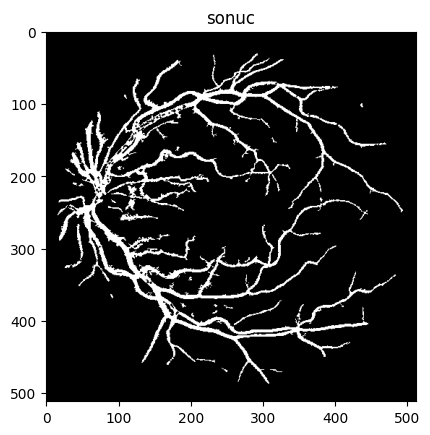

In [7]:
def create_mask(img):
    return np.ones(img.shape[:2], dtype="uint8") * 255

def make_contours(img, mask):
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= 5:
            cv2.drawContours(mask, [contour], -1, 0, -1)

def make_bitwise(img, noise_mask):
    return cv2.bitwise_and(img, img, mask=noise_mask)

noisemask = create_mask(binary_goruntu)
make_contour = make_contours(binary_goruntu , noisemask)
masked = make_bitwise(binary_goruntu , noisemask)

goster(masked)

0.6056349688172636


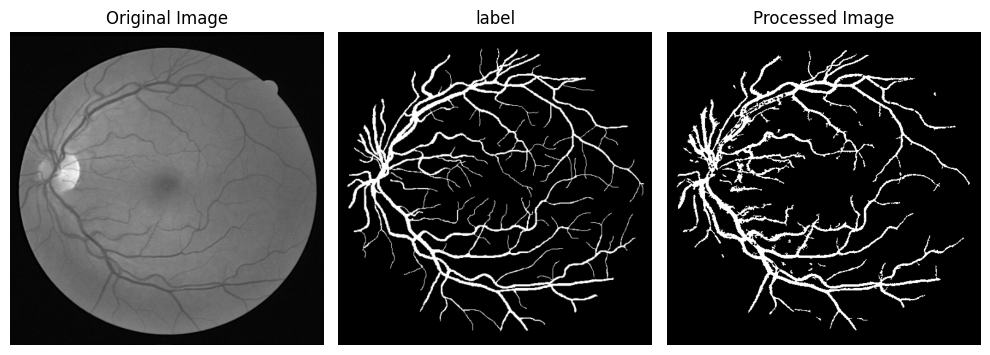

In [8]:
def calculate_iou(pred, label):
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / union if union != 0 else 0

label= cv2.imread(r"..\sample\label.png")
label=label[:, :, 1]
print(calculate_iou(masked, label))

# Visualizing the result
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.imshow(img_green, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(label, cmap='gray')
plt.title("label")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked, cmap='gray')
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()